In [5]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import collections
import random
import matplotlib.pyplot as plt
import pyautogui as pag
import PIL
import torchvision.transforms as transforms
import cv2
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import time
import seaborn as sns


pag.FAILSAFE = False


In [6]:
#device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cuda:0')
writer = SummaryWriter()
train_time = 0

# DQN 모델 정의
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        self.actor_linear = nn.Sequential(nn.Linear(462848, 256),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(256, num_actions))
        #print(f"5 / {time.time()}")

    def forward(self, x):  # 각 action에 대한 가치를 softmax를 거쳐서 확률로 출력
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.actor_linear(x.reshape(x.size(0), -1))
        #x1 = x.to("cpu")
        #x1 = x1.detach().numpy()
        #x1 = np.insert(x1, 0, 0, axis=1)
        #x1 = np.insert(x1, 4, 0, axis=1)
        #x1 = np.append(x1, [[0,0,0]], axis=1)  # axis=0 행으로 값 추가
        #x1 = np.reshape(x1,(4,4))
        #plt.title("Weight heatmap", y = 1.05, size = 15)
        #sns.heatmap(x1, cmap="autumn", linewidths = 0.1, linecolor = "white",annot = True, annot_kws = {"size" : 16})
        #plt.show()
        return x
    
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 10)
        else:
            return out.argmax().item()

action_list = [[2720, 550], [2860, 550], [3000, 550], [2720 ,660], [2860, 660], [3000, 660], [2765, 900], [2855, 930], [2950, 900], [3055, 900], [-1, -1]]
#action list 정의. action list는 6개의 필드 위치와 4개의 카드 위치 그리고 한개의 아무것도 안하는 리워드를 주었다.
action_list_name = {0:'left top', 1:'center top', 2:'right top', 3:'right bottom', 4:'center bottom', 5:'center right', 6:'card 1', 7:'card 2', 8:'card 3', 9:'card 4', 10:'rest action'}


class ENV():
    def __init__(self):
        # screenshot의 위치 지정, 클래스 생성할때 가져오기

        # winflg와 lose flag 존재해야 함. 0으로 하는 건 grayscale
        self.winFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/weWin.png', 0)
        self.loseFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemyWin.png', 0)
        # nocard flag
        self.nocardFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/test1/nocard.png')
        # noElixir flag
        self.noelixirFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/test1/noElixir.png')
        self.startGameFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/battleStart.png')
        self.finishFlag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/battleFinish.png')
        self.enemy1Flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy1.png')
        self.enemy2Flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy2.png')
        self.enemy3Flag = cv2.imread('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy3.png')
    def return_state(self, img):
        # 스크린 샷을 인자로 받아와서 모델에 넣을 수 있도록 tensor로 변환
        tf = transforms.ToTensor()
        img_t = tf(img) # time.sleep(0.3)
        img_t = img_t.unsqueeze(0)
        # img_t = img_t.permute(1, 0, 2, 3)

        return img_t

    def check_finish(self,img):
    	finishMessage = cv2.cvtColor(self.finishFlag, cv2.COLOR_BGR2GRAY)
    	img = np.array(img)
    	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    	ratio = cv2.matchTemplate(finishMessage, img, cv2.TM_CCOEFF_NORMED)
    	if (np.max(ratio) > 0.90):
    	    return 1
    	    
    	else:
    	    return 0
    	                
    def check_win(self, img):
        # 게임이 이겼는지 확인, screenshot을 가져와서 우리가 원하는 크기로 잘라서 확인
        # img = np.array(img)
        checkFlag1 = np.array(img.crop((225, 335, 280, 365)))
        checkFlag1 = cv2.cvtColor(checkFlag1, cv2.COLOR_BGR2GRAY)
        win_check = cv2.matchTemplate(checkFlag1, self.winFlag, cv2.TM_CCOEFF_NORMED)
        if win_check > 0.8:
            return 1

        else:
            return 0
           
    def check_lose(self, img):
        # 게임이 졌는지 확인, screenshot을 가져와서 우리가 원하는 크기로 잘라서 확인
        # img = np.array(img)
        checkFlag2 = np.array(img.crop((225, 85, 280, 115)))
        checkFlag2 = cv2.cvtColor(checkFlag2, cv2.COLOR_BGR2GRAY)
        lose_check = cv2.matchTemplate(checkFlag2, self.loseFlag, cv2.TM_CCOEFF_NORMED)
        if lose_check > 0.8:
            return 1

        else:
            return 0

    def check_card(self, img):
        # 카드를 선택하지 않았는지 확인, screenshot을 가져와서 init에 지정된 nocard 이미지와 비교하여 reward 부여
        nocard = cv2.cvtColor(self.nocardFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(nocard, img, cv2.TM_CCOEFF_NORMED)

        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0

    def check_elixir(self, img):
        noElixir = cv2.cvtColor(self.noelixirFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(noElixir, img, cv2.TM_CCOEFF_NORMED)

        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0

    def checkET1(self, img):
        score1 = 0
        checkFlag1 = np.array(img.crop((105, 135, 155, 136)))

        for i in range(50):
            if (checkFlag1[0][i][0] >= 96):
                score1 += 1

        score1 = score1 * 2
        return score1

    def checkET2(self, img):
        score2 = 0
        checkFlag2 = np.array(img.crop((371, 135, 421, 136)))

        for i in range(50):
            if (checkFlag2[0][i][0] >= 96):
                score2 += 1

        score2 = score2 * 2
        return score2

    def checkGameStart(self, img):
        startMessage = cv2.cvtColor(self.startGameFlag, cv2.COLOR_BGR2GRAY)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(startMessage, img, cv2.TM_CCOEFF_NORMED)
        if (np.max(ratio) > 0.90):
            # print(np.max(ratio))
            return 1

        else:
            return 0

    def enemy1(self, img):
        crownFlag1 = cv2.cvtColor(self.enemy1Flag, cv2.COLOR_BGR2GRAY)
        img1 = np.array(img)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(crownFlag1, img1, cv2.TM_CCOEFF_NORMED)
        #print(np.max(ratio))
        if (np.max(ratio) > 0.90):
            return 1
        else:
            return 0
        
    def enemy2(self, img):
        crownFlag2 = cv2.cvtColor(self.enemy2Flag, cv2.COLOR_BGR2GRAY)
        img1 = np.array(img)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(crownFlag2, img1, cv2.TM_CCOEFF_NORMED)
        #print(np.max(ratio))
        if (np.max(ratio) > 0.90):
            return 1
        else:
            return 0
        
    def enemy3(self, img):
        crownFlag3 = cv2.cvtColor(self.enemy3Flag, cv2.COLOR_BGR2GRAY)
        img1 = np.array(img)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        ratio = cv2.matchTemplate(crownFlag3, img1, cv2.TM_CCOEFF_NORMED)
        #print(np.max(ratio))
        if (np.max(ratio) > 0.90):
            return 1
        else:
            return 0

    # def checkOT1
    # def checkOT1
    # def checkOT1

    # 우리 타워와 상대 타워의 hp를 확인하여 reward 부여

    def retryGame(self):
        time.sleep(3)
        pag.click((2860, 875))
        time.sleep(5)
        pag.click((3070, 185))
        time.sleep(5)
        pag.click((2920, 385))
        time.sleep(3)
        pag.click((2950, 615))


class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque()
        self.batch_size = 50
        self.size_limit = 1500

    def put(self, data):
        self.buffer.append(data)
        if len(self.buffer) > self.size_limit:
            self.buffer.popleft()

    def sample(self, n):
        print(f"self.buffer = {len(self.buffer)}")
        return random.sample(self.buffer, n)

    def size(self):
        return len(self.buffer)


def train(q, q_target, memory, gamma, optimizer, batch_size):
    global train_time
    for i in range(100):
        # print(f"batch_size = {batch_size}, memory.size = {memory.size()}")
        batch = memory.sample(batch_size)
        # print(f"size = {len(batch[0])}")
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in batch:
            
            s, a, r, s_prime, done_mask = transition
            s, s_prime, = s.cuda(), s_prime.cuda()  
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])      
           
            #s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = s_lst.cuda(), a_lst.cuda(), r_lst.cuda(), s_prime_lst.cuda(), done_mask_lst.cuda() 
        s_lst = torch.stack(s_lst).cuda()
        s_prime_lst = torch.stack(s_prime_lst).cuda()
        # print(f"about s = {type(s_lst)}")
        s, a, r, s_prime, done_mask = s_lst, torch.tensor(a_lst).cuda(), \
            torch.tensor(r_lst).cuda(), s_prime_lst, \
            torch.tensor(done_mask_lst).cuda()
                # print(f"about S = {type(s)}")
        s = s.squeeze()
        s_prime = s_prime.squeeze()
        q_out = q(s)
        
        q_a = q_out.gather(1, a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)

        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(target, q_a)
        print(f"loss = {loss}")
        if train_time % 100 == 0:
            writer.add_scalar("Loss/train", loss, train_time)
            writer.flush()
        train_time += 1
        #writer.add_scalar("Loss/train", loss, train_time)
        #writer.flush()

        optimizer.zero_grad()
        #print("we got the end1")
        loss.backward()
        #print("we got the end2")
        optimizer.step()
        #print("we got the end3")

2023-07-12 21:46:10.109337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
env = ENV()
q = DQN(len(action_list))
q = q.cuda()
q_target = DQN(len(action_list))
q_target = q_target.cuda()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

avg_t = 0
gamma = 0.98
batch_size = 50
optimizer = optim.Adam(q.parameters(), lr = 0.0005)

middleBuffer = []

n_epi = 0
done = 0

while (1):
    # s 변수 설정
    # region 에 left, top, width, height 형식으로 넘겨주면 된다.
    img = pag.screenshot(region=(2605, 100, 510, 900))
    img_t = env.return_state(img)
    s = img_t

    # reward 초기화
    reward = 0
    # enemy tower score / score1 = left, score2 = right
    score1 = 100
    score2 = 100
    t1 = time.time()
    start_flag = 0
    print("waiting for the battle to begin")

    while (1):
        while (start_flag == 0):
            # 스크린샷 찍기
            img = pag.screenshot(region=(2605, 100, 510, 900))

            if (env.checkGameStart(img)):
                # print("game start")
                time.sleep(2)
                pag.click((2860, 875))
                time.sleep(1)
                pag.click((2860, 875))
                start_flag = 1
                break
        # epsilon 조절
        epsilon = max(0.1, 0.5 - 0.01 * (train_time / 200))
        n_epi += 1
        print("==================================================")
        reward -= 1
        # 스크린샷 찍기
        img = pag.screenshot(region=(2605, 100, 510, 900))
        print(f"episode = {n_epi}")
        # 모델에 넣기 위해 tensor로 변환
        img_t = env.return_state(img)
        img_t = img_t.cuda()
        s_prime = img_t
        a = q.sample_action(img_t, epsilon)
        
        

        if(a!=10):
            # 화면 클릭
            pag.click(action_list[a][0], action_list[a][1])
            
        # 승리 확인
        if (env.check_win(img)):
            print("win")
            reward += 50000
            done = 1
        # 패배 확인
        if (env.check_lose(img)):
            print("lose")
            reward -= 50000
            done = 1
        # no card확인
        if (env.check_card(img)):
            reward -= 10
            print("no card")

        # no elixir확인
        if (env.check_elixir(img)):
            reward -= 1
            print("no Elixir")
            
        if (env.enemy1(img)):
            reward -= 100
            print("crown - 1")
        
        if (env.enemy2(img)):
            reward -= 100
            print("crown - 2")
        
        if (env.enemy3(img)):
            reward -= 50000
            done = 1
            print("crown - 3")


        # enemy tower reward calculate
        score1_now = env.checkET1(img)
        score2_now = env.checkET2(img)
        #print(f"score1 = {score1}, score1_now = {score1_now}")
        #print(f"score2 = {score2}, score2_now = {score2_now}")
        print(f"left tower HP = {score1}, right tower HP = {score2}")
        if (score1_now < score1):
            reward += 16 * (score1 - score1_now)
            score1 = score1_now

        if (score2_now < score2):
            reward += 16 * (score2 - score2_now)
            score2 = score2_now
            
        middleBuffer.append((s, a, reward, s_prime, done))
        #이부분 잘못된듯 -> epi 별 reward가 아니라 게임당 reward여야 될 듯
        
        print('action =', action_list_name[a], '    index = ', action_list[a][0], action_list[a][1])
        print("reward = ", reward)
        

        s = s_prime

        #속도조절
        time.sleep(0.3)

        if done == 1:
            break

    # memory size 2000넘으면 학습 시작
    if len(middleBuffer) >= 20:
        print(time.time() - t1)
        for i in range(len(middleBuffer)):
            memory.put(middleBuffer[i])

        print(len(memory.buffer))
        print("========================")
        # print(middleBuffer.size())
        middleBuffer = []

        train(q, q_target, memory, gamma, optimizer, batch_size)

        print(f"train time = {train_time}")
        q_target.load_state_dict(q.state_dict())
        print(f"epi = {n_epi}, buffer size = {memory.size()}, epsilon = {epsilon}")
        
    if train_time % 2000 == 0:
        # reak
        torch.save(q.state_dict(),"{}/clash_royale_DQN_{}".format("trained_models", train_time))
#         a = []
#         b = []
#         c = []
#         layer = 2
#         for i in range(q.conv1[0].weight.shape[0]):
#             q1 = q.conv1[0].weight[i][0]
#             q1 = q1.to("cpu")
#             q1 = q1.detach().numpy()
#             q1 = np.ravel(q1, order='C')
#             a.append(q1)
#             q2 = q.conv1[0].weight[i][1]
#             q2 = q2.to("cpu")
#             q2 = q2.detach().numpy()
#             q2 = np.ravel(q2, order='C') 
#             b.append(q2)
#             q3 = q.conv1[0].weight[i][2]
#             q3 = q3.to("cpu")
#             q3 = q3.detach().numpy()
#             q3 = np.ravel(q3, order='C')
#             c.append(q3)
#         a = np.ravel(a, order='C')
#         a = a.reshape(12, 12)   
#         sns.heatmap(a, cmap='hot')
#         plt.show()
#         b = np.ravel(b, order='C')
#         b = b.reshape(12, 12)   
#         sns.heatmap(b, cmap='hot')
#         plt.show()
#         c = np.ravel(c, order='C')
#         c = c.reshape(12, 12)   
#         sns.heatmap(c, cmap='hot')
#         plt.show()
    writer.add_scalar("reward/train", reward, train_time)
    writer.flush()
    env.retryGame()
    done = 0
    time.sleep(5)
     


waiting for the battle to begin


KeyboardInterrupt: 

In [ ]:
img = pag.screenshot(region=(2605, 100, 510, 900))
plt.imshow(img)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


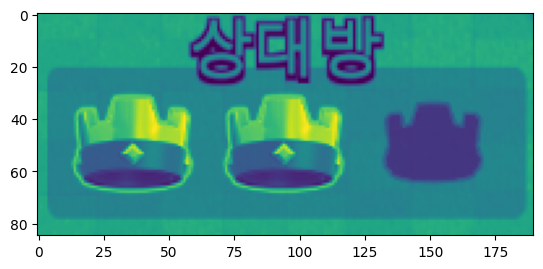

In [104]:
crownFlag1= np.array(img.crop((160, 215, 350, 300)))
plt.imshow(checkFlag2)

True

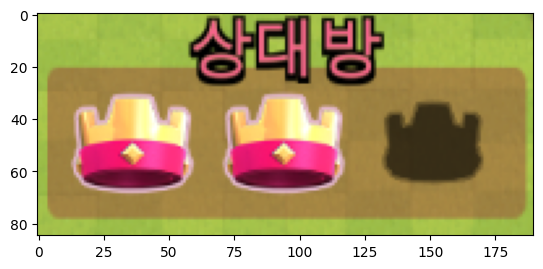

In [75]:
#img = pag.screenshot(region=(2605, 100, 510, 900))
#print(env.check_lose(img))
checkFlag2 = np.array(img.crop((160, 215, 350, 300)))
plt.imshow(checkFlag2)
cv2.imwrite('/home/jnu/Desktop/Reinforce/Royale/screenshot/cr_test/enemy2.png', checkFlag2)

In [38]:
checkFlag2 = np.array(img.crop((225, 85, 280, 115)))

In [ ]:
print(q.conv1[0].in_channels)
print(q.conv1[0].out_channels)
        #x1 = x.to("cpu")
        #x1 = x1.detach().numpy()
        #x1 = np.insert(x1, 0, 0, axis=1)
        #x1 = np.insert(x1, 4, 0, axis=1)
        #x1 = np.append(x1, [[0,0,0]], axis=1)  # axis=0 행으로 값 추가
        #x1 = np.reshape(x1,(4,4))
        #plt.title("Weight heatmap", y = 1.05, size = 15)
        #sns.heatmap(x1, cmap="autumn", linewidths = 0.1, linecolor = "white",annot = True, annot_kws = {"size" : 16})
        #plt.show()

In [94]:
q.conv1[0].weight[0]

tensor([[[-0.1910,  0.0657,  0.1492],
         [-0.1569, -0.1872, -0.0375],
         [ 0.0141, -0.0596, -0.0620]],

        [[ 0.1852, -0.1182, -0.1788],
         [-0.0704,  0.0579, -0.1374],
         [-0.0600, -0.1272, -0.0678]],

        [[-0.1710, -0.0985,  0.0243],
         [ 0.0894, -0.0798,  0.1439],
         [-0.0811,  0.0274, -0.0341]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [50]:
q1 = q.conv1[0].weight[0][0]
q1 = q1.to("cpu")
q1=q1.detach().numpy()

In [51]:
np.ravel(q1, order='C')

array([-0.19103229,  0.06570474,  0.14923981, -0.15693238, -0.18720873,
       -0.03745046,  0.01411462, -0.0595714 , -0.06198703], dtype=float32)

In [55]:
q.conv1[0].weight[1][0]

tensor([[-0.0305, -0.1291,  0.1786],
        [-0.0957, -0.0133, -0.0801],
        [-0.0670,  0.1225, -0.0574]], device='cuda:0',
       grad_fn=<SelectBackward0>)

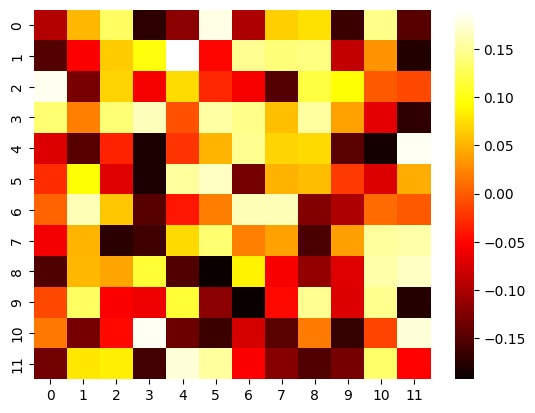

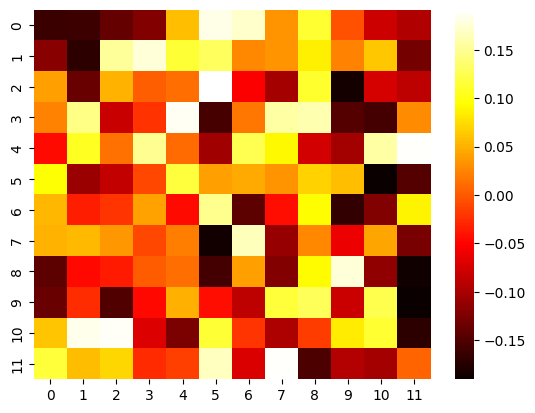

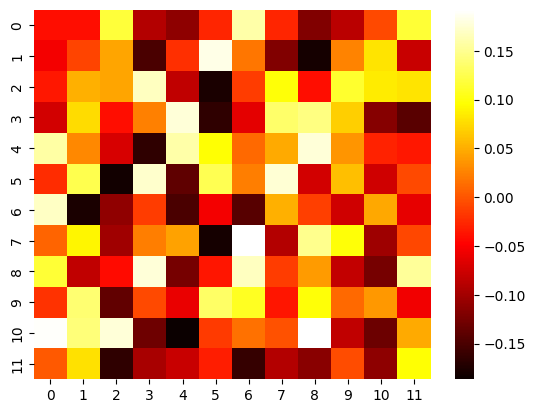

In [9]:
a = []
b=[]
c=[]
layer = 2
for i in range(q.conv1[0].weight.shape[0]):
    q1 = q.conv1[0].weight[i][0]
    q1 = q1.to("cpu")
    q1 = q1.detach().numpy()
    q1 = np.ravel(q1, order='C')
    a.append(q1)
    q2 = q.conv1[0].weight[i][1]
    q2 = q2.to("cpu")
    q2 = q2.detach().numpy()
    q2 = np.ravel(q2, order='C') #ㅎㅇㅎㅇㅎㅇㅎㅇㅎㅇㅎㅇ3안녕? 너 일단 할거해
    b.append(q2)
    q3 = q.conv1[0].weight[i][2]
    q3 = q3.to("cpu")
    q3 = q3.detach().numpy()
    q3 = np.ravel(q3, order='C')
    c.append(q3)
a = np.ravel(a, order='C')
a = a.reshape(12, 12)   
sns.heatmap(a, cmap='hot')
plt.show()
b = np.ravel(b, order='C')
b = b.reshape(12, 12)   
sns.heatmap(b, cmap='hot')
plt.show()
c = np.ravel(c, order='C')
c = c.reshape(12, 12)   
sns.heatmap(c, cmap='hot')
plt.show()

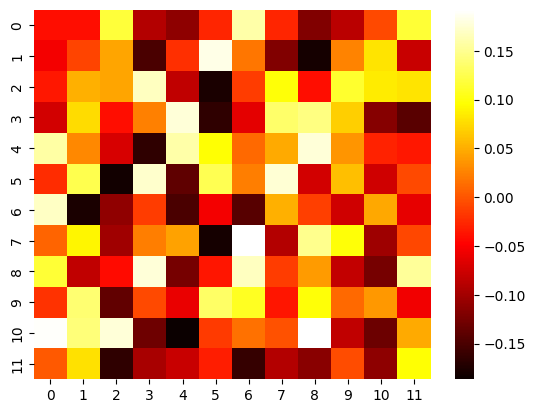

In [7]:
sns.heatmap(a, cmap='hot')
plt.show()     

In [6]:
q.conv1[0]

Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [8]:
q.conv1[0].weight

Parameter containing:
tensor([[[[-0.1763,  0.1101, -0.1895],
          [-0.0492,  0.0585, -0.0273],
          [ 0.0278,  0.0520,  0.0017]],

         [[ 0.0356, -0.1228, -0.0450],
          [ 0.0269,  0.1062,  0.0014],
          [-0.0567, -0.1588,  0.1233]],

         [[ 0.0646,  0.1213,  0.1769],
          [ 0.0969,  0.1143, -0.0974],
          [-0.0146,  0.1350,  0.0694]]],


        [[[-0.0149, -0.1712, -0.0329],
          [-0.0655,  0.0070, -0.1664],
          [ 0.0603,  0.1577,  0.1888]],

         [[ 0.0605,  0.1317, -0.0412],
          [-0.1615,  0.0245, -0.0953],
          [ 0.1340, -0.0809, -0.0134]],

         [[-0.1591,  0.0205,  0.0272],
          [ 0.0890, -0.1222,  0.1412],
          [ 0.1244,  0.0753, -0.0512]]],


        [[[-0.1570, -0.0613,  0.1749],
          [-0.1081, -0.1779, -0.1305],
          [ 0.1085,  0.0962, -0.1438]],

         [[-0.1118, -0.1327, -0.0184],
          [-0.1789, -0.0698, -0.0759],
          [-0.0646,  0.0879, -0.1843]],

         [[ 0.0686, -0